In [2]:
import sys
from collections import defaultdict
import cv2
import numpy as np
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F

In [3]:
#!pip install cv2

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import yaml
from PIL import Image
from IPython.display import Video

In [5]:
import wandb

# Initialize wandb
wandb.init(project='Faster_RCNN', name='Optimized_run6')


wandb: Currently logged in as: aishwaryavs12. Use `wandb login --relogin` to force relogin


In [6]:
!pip install -U ipywidgets

In [7]:
#Data Annotation Change

In [8]:
import os
import shutil
import xml.etree.ElementTree as ET
from PIL import Image
import yaml

# Define the dataset path
dataset_path = '/home/hice1/asheelvant3/Traffic_dataset'
dataset_path2 = '/home/hice1/asheelvant3/FasterRCNN_data2'

# Set the path to the YAML file
yaml_file_path = os.path.join(dataset_path, 'data.yaml')

# Load and print the contents of the YAML file
with open(yaml_file_path, 'r') as file:
    yaml_content = yaml.load(file, Loader=yaml.FullLoader)
print(yaml.dump(yaml_content, default_flow_style=False))

# Paths for YOLO and VOC format
yolo_train_path = os.path.join(dataset_path, 'train', 'images')
yolo_train_labels_path = os.path.join(dataset_path, 'train', 'labels')
yolo_valid_path = os.path.join(dataset_path, 'valid', 'images')
yolo_valid_labels_path = os.path.join(dataset_path, 'valid', 'labels')

voc_train_path = os.path.join(dataset_path2, 'train')
voc_train_images_path = os.path.join(voc_train_path, 'images')
voc_train_annotations_path = os.path.join(voc_train_path, 'annotations')

voc_valid_path = os.path.join(dataset_path2, 'valid')
voc_valid_images_path = os.path.join(voc_valid_path, 'images')
voc_valid_annotations_path = os.path.join(voc_valid_path, 'annotations')

# Create the VOC directory structure
os.makedirs(voc_train_images_path, exist_ok=True)
os.makedirs(voc_train_annotations_path, exist_ok=True)
os.makedirs(voc_valid_images_path, exist_ok=True)
os.makedirs(voc_valid_annotations_path, exist_ok=True)

# Convert YOLO annotations to PASCAL VOC format
for filename in os.listdir(yolo_train_labels_path):
    if filename.endswith('.txt'):
        image_filename = os.path.splitext(filename)[0] + '.jpg'
        image_path = os.path.join(yolo_train_path, image_filename)
        image = Image.open(image_path)
        width, height = image.size

        with open(os.path.join(yolo_train_labels_path, filename), 'r') as f:
            lines = f.readlines()

        root = ET.Element('annotation')
        ET.SubElement(root, 'filename').text = image_filename
        size = ET.SubElement(root, 'size')
        ET.SubElement(size, 'width').text = str(width)
        ET.SubElement(size, 'height').text = str(height)
        depth = image.getbands()
        ET.SubElement(size, 'depth').text = str(len(depth))

        for line in lines:
            values = line.strip().split()
            class_id = int(values[0])
            x_center = float(values[1])
            y_center = float(values[2])
            width_norm = float(values[3])
            height_norm = float(values[4])

            # Calculate bounding box coordinates
            x_min = int((x_center - width_norm / 2) * width)
            y_min = int((y_center - height_norm / 2) * height)
            x_max = int((x_center + width_norm / 2) * width)
            y_max = int((y_center + height_norm / 2) * height)

            obj = ET.SubElement(root, 'object')
            ET.SubElement(obj, 'name').text = yaml_content['names'][class_id]
            bndbox = ET.SubElement(obj, 'bndbox')
            ET.SubElement(bndbox, 'xmin').text = str(x_min)
            ET.SubElement(bndbox, 'ymin').text = str(y_min)
            ET.SubElement(bndbox, 'xmax').text = str(x_max)
            ET.SubElement(bndbox, 'ymax').text = str(y_max)

        tree = ET.ElementTree(root)
        tree.write(os.path.join(voc_train_annotations_path, os.path.splitext(filename)[0] + '.xml'))
        shutil.copy(image_path, os.path.join(voc_train_images_path, image_filename))

# Repeat the same process for the validation set
for filename in os.listdir(yolo_valid_labels_path):
    if filename.endswith('.txt'):
        image_filename = os.path.splitext(filename)[0] + '.jpg'
        image_path = os.path.join(yolo_valid_path, image_filename)
        image = Image.open(image_path)
        width, height = image.size

        with open(os.path.join(yolo_valid_labels_path, filename), 'r') as f:
            lines = f.readlines()

        root = ET.Element('annotation')
        ET.SubElement(root, 'filename').text = image_filename
        size = ET.SubElement(root, 'size')
        ET.SubElement(size, 'width').text = str(width)
        ET.SubElement(size, 'height').text = str(height)
        depth = image.getbands()
        ET.SubElement(size, 'depth').text = str(len(depth))

        for line in lines:
            values = line.strip().split()
            class_id = int(values[0])
            x_center = float(values[1])
            y_center = float(values[2])
            width_norm = float(values[3])
            height_norm = float(values[4])

            # Calculate bounding box coordinates
            x_min = int((x_center - width_norm / 2) * width)
            y_min = int((y_center - height_norm / 2) * height)
            x_max = int((x_center + width_norm / 2) * width)
            y_max = int((y_center + height_norm / 2) * height)

            obj = ET.SubElement(root, 'object')
            ET.SubElement(obj, 'name').text = yaml_content['names'][class_id]
            bndbox = ET.SubElement(obj, 'bndbox')
            ET.SubElement(bndbox, 'xmin').text = str(x_min)
            ET.SubElement(bndbox, 'ymin').text = str(y_min)
            ET.SubElement(bndbox, 'xmax').text = str(x_max)
            ET.SubElement(bndbox, 'ymax').text = str(y_max)

        tree = ET.ElementTree(root)
        tree.write(os.path.join(voc_valid_annotations_path, os.path.splitext(filename)[0] + '.xml'))
        shutil.copy(image_path, os.path.join(voc_valid_images_path, image_filename))

print("Conversion to PASCAL VOC format completed.")


names:
- Vehicle
nc: 1
roboflow:
  license: CC BY 4.0
  project: vehicle_detection_yolov8
  url: https://universe.roboflow.com/farzad/vehicle_detection_yolov8/dataset/3
  version: 3
  workspace: farzad
train: ../train/images
val: ../valid/images

Conversion to PASCAL VOC format completed.


In [9]:
dataset_path2

'/home/hice1/asheelvant3/FasterRCNN_data2'

In [10]:
train_images_path = os.path.join(dataset_path2, 'train', 'images')

In [11]:
train_images_path = os.path.join(dataset_path2, 'train', 'images')
valid_images_path = os.path.join(dataset_path2, 'valid', 'images')

# Initialize counters for the number of images
num_train_images = 0
num_valid_images = 0

# Initialize sets to hold the unique sizes of images
train_image_sizes = set()
valid_image_sizes = set()

# Check train images sizes and count
for filename in os.listdir(train_images_path):
    if filename.endswith('.jpg'):  
        num_train_images += 1
        image_path = os.path.join(train_images_path, filename)
        with Image.open(image_path) as img:
            train_image_sizes.add(img.size)

# Check validation images sizes and count
for filename in os.listdir(valid_images_path):
    if filename.endswith('.jpg'): 
        num_valid_images += 1
        image_path = os.path.join(valid_images_path, filename)
        with Image.open(image_path) as img:
            valid_image_sizes.add(img.size)

# Print the results
print(f"Number of training images: {num_train_images}")
print(f"Number of validation images: {num_valid_images}")

# Check if all images in training set have the same size
if len(train_image_sizes) == 1:
    print(f"All training images have the same size: {train_image_sizes.pop()}")
else:
    print("Training images have varying sizes.")

# Check if all images in validation set have the same size
if len(valid_image_sizes) == 1:
    print(f"All validation images have the same size: {valid_image_sizes.pop()}")
else:
    print("Validation images have varying sizes.")

Number of training images: 536
Number of validation images: 90
All training images have the same size: (640, 640)
All validation images have the same size: (640, 640)


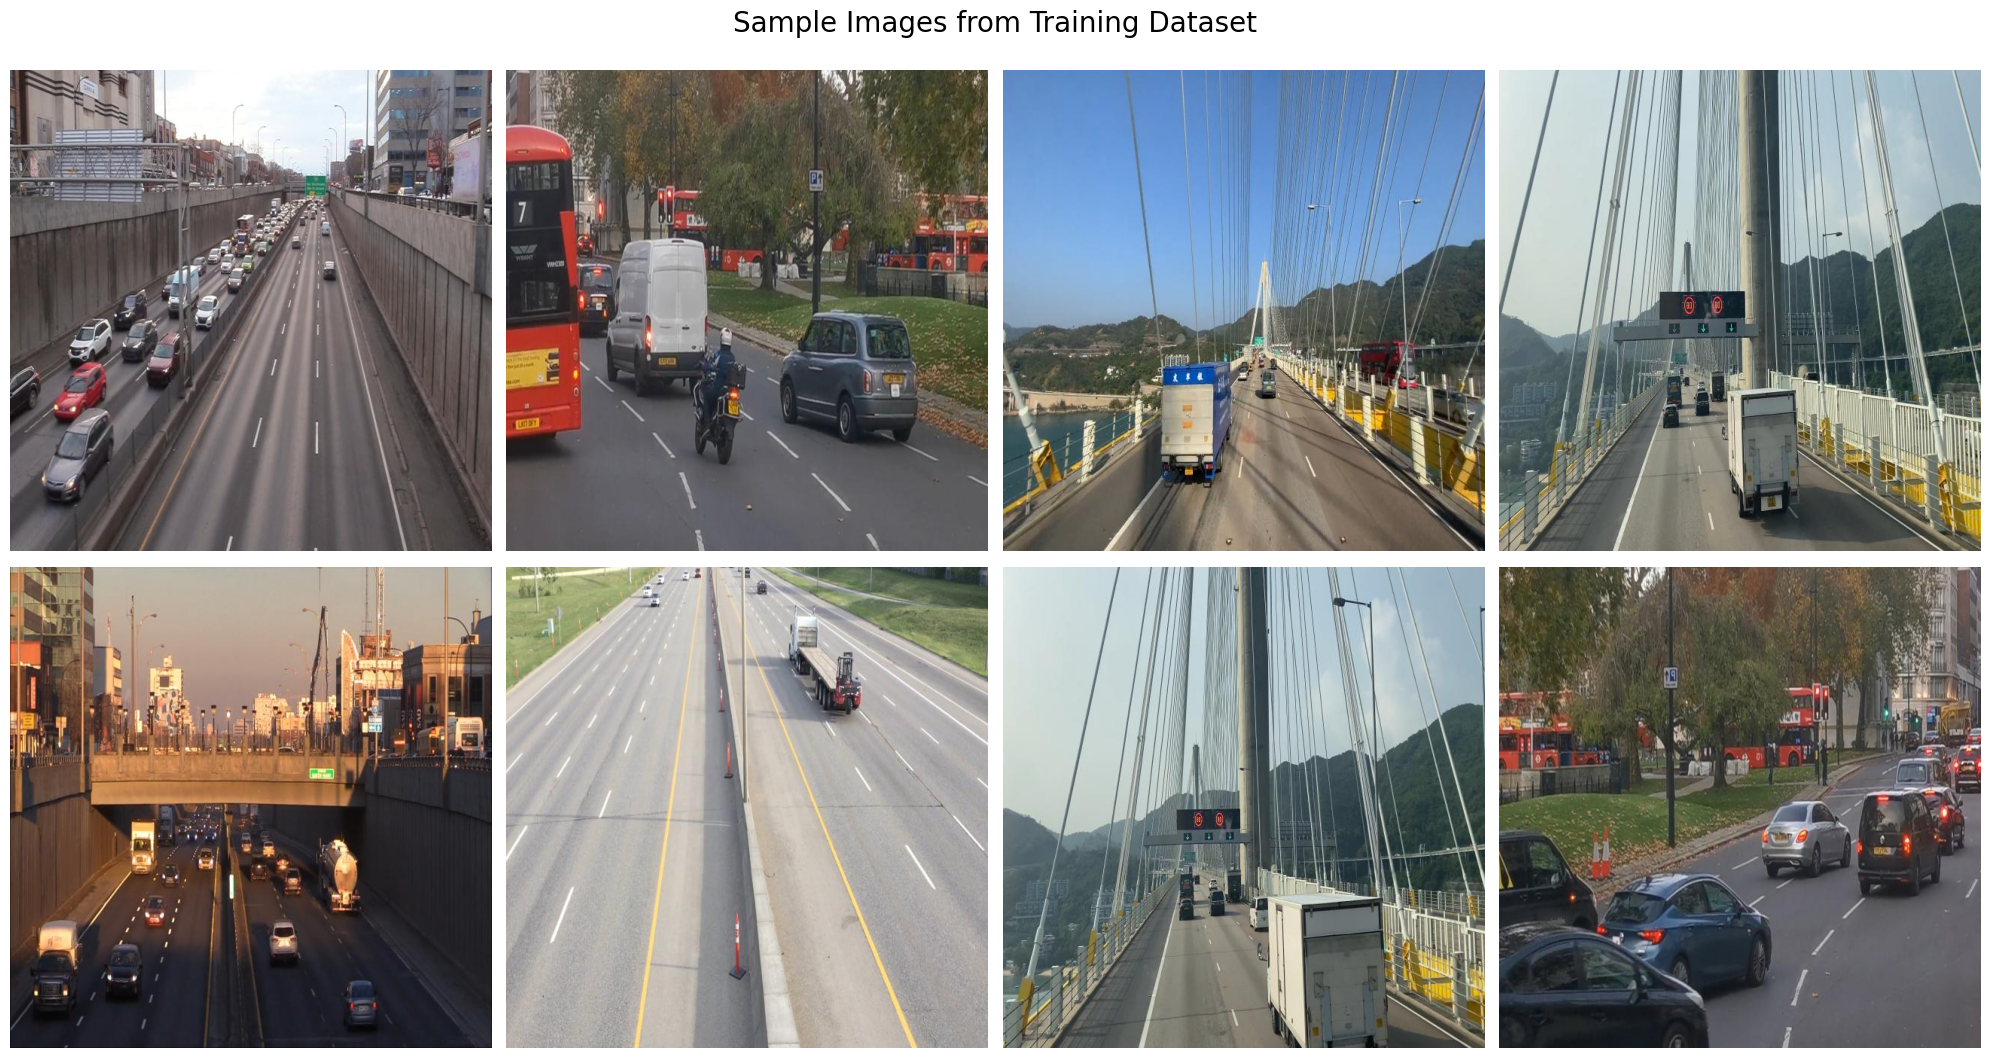

In [12]:
# List all jpg images in the directory
image_files = [file for file in os.listdir(train_images_path) if file.endswith('.jpg')]

# Select 8 images at equal intervals
num_images = len(image_files)
selected_images = [image_files[i] for i in range(0, num_images, num_images // 8)]

# Create a 2x4 subplot
fig, axes = plt.subplots(2, 4, figsize=(20, 11))

# Display each of the selected images
for ax, img_file in zip(axes.ravel(), selected_images):
    img_path = os.path.join(train_images_path, img_file)
    image = Image.open(img_path)
    ax.imshow(image)
    ax.axis('off')  

plt.suptitle('Sample Images from Training Dataset', fontsize=20)
plt.tight_layout()
plt.show()

In [13]:
# Configure the visual appearance of Seaborn plots
sns.set(rc={'axes.facecolor': '#eae8fa'}, style='darkgrid')

In [14]:
model = fasterrcnn_resnet50_fpn(pretrained=True)

In [16]:
import os
import xml.etree.ElementTree as ET
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, root_dir, mode):
        self.root_dir = root_dir
        self.mode = mode
        self.image_dir = os.path.join(root_dir, mode, 'images')
        self.annotation_dir = os.path.join(root_dir, mode, 'annotations')
        self.image_files = os.listdir(self.image_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_filename = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_filename)
        image = Image.open(image_path).convert("RGB")

        annotation_filename = os.path.splitext(image_filename)[0] + '.xml'
        annotation_path = os.path.join(self.annotation_dir, annotation_filename)
        try:
            bboxes, labels = self.load_annotations(annotation_path)
        except Exception as e:
            print(f"Error loading annotations for {image_filename}: {e}")
            return None

        # Create figure and axes
        # fig, ax = plt.subplots(1)
        # ax.imshow(image)

        # Add bounding boxes
        for bbox in bboxes:
            xmin, ymin, xmax, ymax = bbox
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

        # plt.show()

        return image, {
            'boxes': torch.tensor(bboxes, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.int64)
        }

    def load_annotations(self, annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        bboxes = []
        labels = []

        for obj in root.findall('object'):
            name = obj.find('name').text
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)

            # Check if bounding box coordinates are valid
            if xmax <= xmin or ymax <= ymin:
                raise ValueError(f"Invalid bounding box coordinates for {name} in {annotation_path}")

            bboxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)  # Assuming all objects are of the same class

        return bboxes, labels

# Test the dataset
dataset = CustomDataset('/home/hice1/asheelvant3/FasterRCNN_data2', 'train')
image, target = dataset[0]  # Visualize the first image with its bounding boxes


In [17]:
import torchvision.transforms as transforms

In [18]:
# Define your model, optimizer, and other necessary imports
import torchvision.models.detection as detection
import torch.optim as optim

# Define your model
model = detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Define optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
num_epochs = 10
for epoch in range(num_epochs):
    print(epoch)
    model.train()
    running_loss = 0.0
    for idx in range(len(dataset)):  # Iterate over the dataset directly
        optimizer.zero_grad()

        # Get data from dataset
        image, target = dataset[idx]
        if image is None:  # Skip if there's an error loading annotations
            continue

        # Move data to the appropriate device
        # image = image.to(device)
        # target = {k: v.to(device) for k, v in target.items()}
        # image = torch.tensor(image, dtype=torch.float32).to(device)
        # target = {k: v.to(device) for k, v in target.items()}
        transform = transforms.ToTensor()
        image = transform(image).to(device)
        target = {k: v.to(device) for k, v in target.items()}
        # Forward pass
        loss_dict = model([image], [target])

        # Compute total loss
        total_loss = sum(loss for loss in loss_dict.values())

        # Backward pass
        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item()
        wandb.log({'epoch': epoch, 'loss': total_loss.item()})
    wandb.log({'epoch_loss': running_loss / len(dataset)})
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataset)}")


0
Epoch [1/10], Loss: 0.3892312189459856
1
Epoch [2/10], Loss: 0.31115723230681425
2
Epoch [3/10], Loss: 0.27712306950533233
3
Epoch [4/10], Loss: 0.2502150380837995
4
Epoch [5/10], Loss: 0.23005967939432376
5
Epoch [6/10], Loss: 0.20844922414042555
6
Epoch [7/10], Loss: 0.19089603630839777
7
Epoch [8/10], Loss: 0.18374229924155594
8
Epoch [9/10], Loss: 0.1747788258979389
9
Epoch [10/10], Loss: 0.16247659078590684


In [21]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [22]:
torch.save(model.state_dict(), 'model.pth')

# Save the model to wandb
wandb.save('model.pth')

['/home/hice1/asheelvant3/wandb/run-20240416_142905-azu1179r/files/model.pth']